In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.image_classification.models.highway import HighwayNetwork
from torchvision import transforms
from torchvision.datasets import EuroSAT

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 16

In [3]:
artifact_path = Path("../../artifacts/highway")
data_path = Path("../../data/euroSAT")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
dataset = EuroSAT(
    data_path.as_posix(),
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = len(dataset.classes)

In [9]:
dataset.classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [10]:
len(dataset)

27000

River


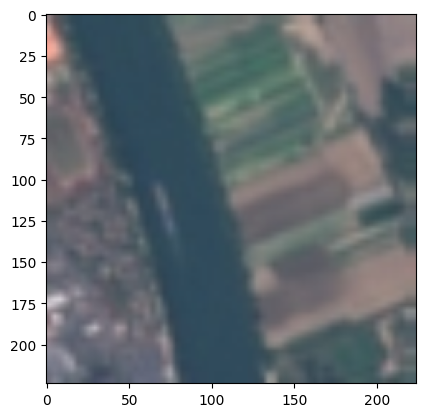

In [11]:
import random
demo_img, demo_label = dataset[random.randint(0, len(dataset))]
print(dataset.classes[demo_label])
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [12]:
model = HighwayNetwork(
    [
        ['c', 3, 32, 3],
        ['p', 0, 0, 0],
        ['c', 32, 32, 3],
        ['c', 32, 32, 3],
        ['c', 32, 64, 3],
        ['p', 0, 0, 0],
        ['c', 64, 64, 3],
        ['c', 64, 64, 3],
        ['c', 64, 128, 3],
        ['p', 0, 0, 0],
        ['c', 128, 128, 3],
        ['c', 128, 128, 3],
        ['c', 128, 256, 3],
        ['p', 0, 0, 0],
        ['c', 256, 256, 3],
        ['c', 256, 256, 3],
        ['c', 256, 512, 3],
    ],
    output_size=num_class,
).to(device)

In [13]:
torchinfo.summary(model)

Layer (type:depth-idx)                                  Param #
HighwayNetwork                                          --
├─Sequential: 1-1                                       --
│    └─HighwayLayer: 2-1                                --
│    │    └─Conv2dNormActivation: 3-1                   160
│    │    └─HighwayBlock: 3-2                           18,560
│    └─MaxPool2d: 2-2                                   --
│    └─HighwayLayer: 2-3                                --
│    │    └─Identity: 3-3                               --
│    │    └─HighwayBlock: 3-4                           18,560
│    └─HighwayLayer: 2-4                                --
│    │    └─Identity: 3-5                               --
│    │    └─HighwayBlock: 3-6                           18,560
│    └─HighwayLayer: 2-5                                --
│    │    └─Conv2dNormActivation: 3-7                   2,176
│    │    └─HighwayBlock: 3-8                           73,984
│    └─MaxPool2d: 2-6          

# training

In [14]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

In [15]:
epochs = 10
acc_iters = 64 // BATCH_SIZE

In [16]:
trainer = ClassificationTrainer(epochs, device, acc_iters)

In [17]:
training_loss = trainer.run(train_loader, model, optim, criterion)

100%|██████████| 1687/1687 [11:58<00:00,  2.35it/s]


epoch 1 : 0.017135328173231074


100%|██████████| 1687/1687 [03:46<00:00,  7.44it/s]


epoch 2 : 0.009524248473464374


100%|██████████| 1687/1687 [03:45<00:00,  7.48it/s]


epoch 3 : 0.006740239637683874


100%|██████████| 1687/1687 [03:52<00:00,  7.27it/s]


epoch 4 : 0.005223924981530371


100%|██████████| 1687/1687 [03:58<00:00,  7.08it/s]


epoch 5 : 0.004258925823822784


100%|██████████| 1687/1687 [04:00<00:00,  7.02it/s]


epoch 6 : 0.003786901134852898


100%|██████████| 1687/1687 [04:00<00:00,  7.01it/s]


epoch 7 : 0.0034714413232577674


100%|██████████| 1687/1687 [03:54<00:00,  7.18it/s]


epoch 8 : 0.0030680420836610256


100%|██████████| 1687/1687 [04:19<00:00,  6.51it/s]


epoch 9 : 0.0028980892998762327


100%|██████████| 1687/1687 [03:57<00:00,  7.11it/s]

epoch 10 : 0.0026127335010098156


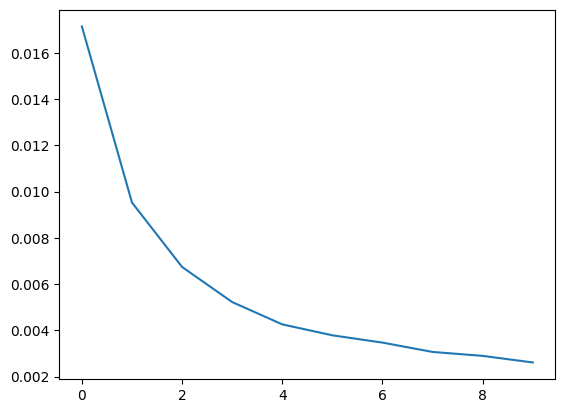

In [18]:
plt.plot(training_loss)

# inference

In [19]:
test_preprocess = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [20]:
test_dataset = EuroSAT(
    data_path.as_posix(),
    transform=test_preprocess,
    download=True,
)

In [21]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [22]:
evaluator = ClassificationEvaluator(num_class, device)

In [23]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 1688/1688 [01:45<00:00, 15.98it/s]

[[2886    1    1   12    0   22    8    0   37   33]
 [   0 2984    5    1    0    0    0    0    4    6]
 [  48   56 2527    8    0   30  287   10   26    8]
 [   7    1    0 2450    1    1    7    0   33    0]
 [   0    0   14   37 2388    0   37   16    8    0]
 [  13   58   13    1    0 1887    2    0   19    7]
 [  85    0   10   14    1   13 2371    0    6    0]
 [   0    0   11    3   10    0   22 2954    0    0]
 [  10    0    4   37    0    3    1    0 2442    3]
 [   3    0    0    1    0    0    0    0   10 2986]]


In [24]:
print(confusion_matrix)

[[2886    1    1   12    0   22    8    0   37   33]
 [   0 2984    5    1    0    0    0    0    4    6]
 [  48   56 2527    8    0   30  287   10   26    8]
 [   7    1    0 2450    1    1    7    0   33    0]
 [   0    0   14   37 2388    0   37   16    8    0]
 [  13   58   13    1    0 1887    2    0   19    7]
 [  85    0   10   14    1   13 2371    0    6    0]
 [   0    0   11    3   10    0   22 2954    0    0]
 [  10    0    4   37    0    3    1    0 2442    3]
 [   3    0    0    1    0    0    0    0   10 2986]]


In [25]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(test_dataset.classes, per_class_acc)

AnnualCrop: 0.962
Forest    : 0.9946666666666667
HerbaceousVegetation: 0.8423333333333334
Highway   : 0.98
Industrial: 0.9552
Pasture   : 0.9435
PermanentCrop: 0.9484
Residential: 0.9846666666666667
River     : 0.9768
SeaLake   : 0.9953333333333333


In [26]:
per_class_acc.mean()

0.9582900000000001

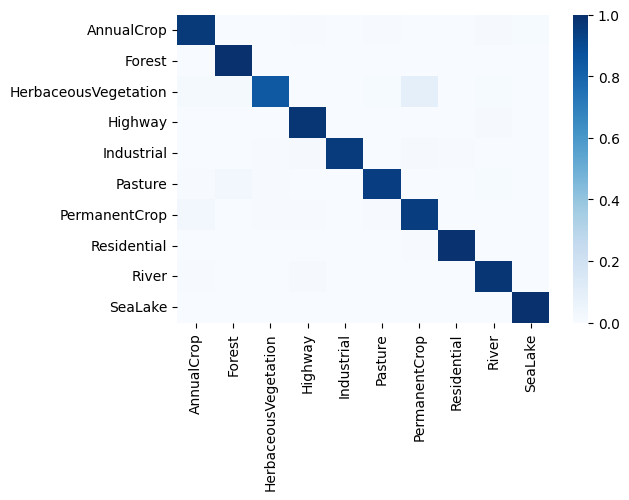

In [27]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    test_dataset.classes,
    "Blues",
    annot=False,
    figsize=(6, 4),
)

In [28]:
model_path = artifact_path / 'highway-cnn.pth'

In [29]:
torch.save(model.state_dict(), model_path)

In [30]:
get_file_size(model_path)

'36.75MB'

In [31]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>